In this one, test the different architectures with the top candidate configurations

## Pre-Loading Data

In [1]:
import os, sys
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import json
import seaborn as sns
from typing import Tuple
from datetime import datetime
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name()
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
else:
    print("⚠️  CUDA not available - running on CPU (will be slow)")

# Performance optimization settings
ENABLE_OPTIMIZATIONS = True  # Set to False to disable all optimizations
ENABLE_PARALLEL_FOLDS = False  # Set to True for cross-validation mode
MAX_PARALLEL_FOLDS = -1  # Adjust based on GPU memory

def load_npy_data(specs_dir: str, specs_csv_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Load spectrograms from .npy files and metadata from CSV.
    
    Args:
        specs_dir (str): Directory containing .npy spectrogram files
        specs_csv_path (str): Path to CSV file containing metadata (filename, class_id, author)
    
    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors.
        Features are already normalized to [0,1] and shaped as (N, 1, 224, 313)
    """
    # Load metadata CSV
    df = pd.read_csv(specs_csv_path)
    
    print(f"Metadata shape: {df.shape}")
    print(f"Number of classes: {df['class_id'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")
    
    # Extract labels and authors
    labels = df['class_id'].values.astype(np.int64)
    authors = df['author'].values
    filenames = df['filename'].values
    
    # Load spectrograms from .npy files
    features_list = []
    valid_indices = []
    
    for i, filename in enumerate(filenames):
        spec_path = os.path.join(specs_dir, filename)
        
        if os.path.exists(spec_path):
            try:
                # Load .npy file - already normalized to [0,1] as float32
                spec_array = np.load(spec_path)
                
                # Add channel dimension: (1, height, width)
                spec_array = spec_array[np.newaxis, ...]
                
                features_list.append(spec_array)
                valid_indices.append(i)
                
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"File not found: {spec_path}")
    
    # Convert to numpy array
    features = np.array(features_list, dtype=np.float32)
    
    # Filter labels and authors to match loaded features
    labels = labels[valid_indices]
    authors = authors[valid_indices]
    
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Authors shape: {authors.shape}")
    print(f"Unique classes: {len(np.unique(labels))}")
    print(f"Unique authors: {len(np.unique(authors))}")
    print(f"Successfully loaded {len(features)} out of {len(filenames)} spectrograms")
    
    # Clean up
    del df
    
    return features, labels, authors

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
GPU Memory: 15.9 GB


Metadata shape: (3702, 3)
Number of classes: 33
Number of authors: 96
Features shape: (3702, 1, 224, 188)
Labels shape: (3702,)
Authors shape: (3702,)
Unique classes: 33
Unique authors: 96
Successfully loaded 3702 out of 3702 spectrograms


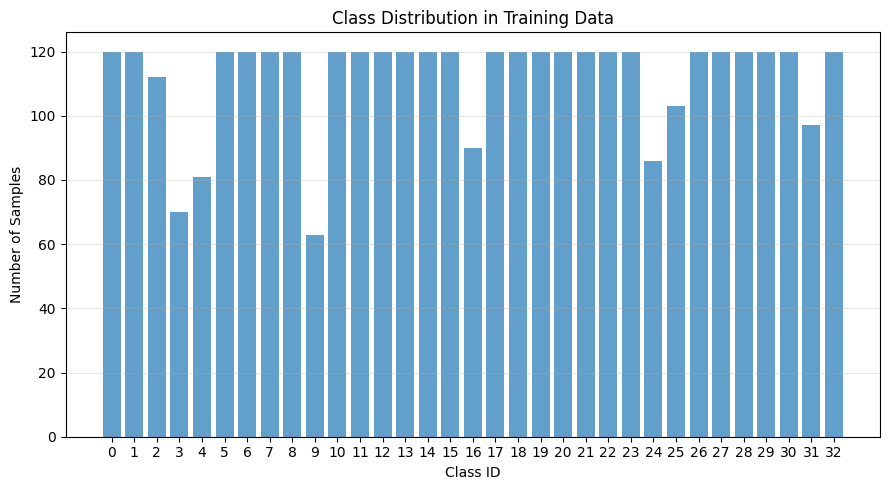

Average samples per class: 112.2


In [2]:
# New pipeline using .npy spectrograms from specs/ directory
specs_dir = os.path.join('..', 'database', 'specs')
specs_csv_path = os.path.join('..', 'database', 'meta', 'final_specs.csv')
features, labels, authors = load_npy_data(specs_dir, specs_csv_path)

# Display class distribution
plt.figure(figsize=(9, 5))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average samples per class: {len(labels) / len(unique_labels):.1f}")

In [ ]:
# Find best seed
from utils.split import precompute_single_fold_split, precompute_kfold_splits, display_split_statistics

# Pre-compute single fold split (for most configurations)
single_fold_split = precompute_single_fold_split(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    max_attempts=250_000,
    min_test_segments=5)

print(f"Single Fold Split Type: {type(single_fold_split)}, Shape: {len(single_fold_split)}")

# Display statistics for verification
display_split_statistics(single_fold_split, "single")

In [ ]:
# # Split with a set seed
# from utils.split import get_set_seed_indices, get_set_seed_kfold_indices, display_split_statistics
# seed_single = 245323 # Quality: 0.2671
# seed_kfold = 11052 # Quality: 0.3332

# single_fold_split = get_set_seed_indices(
#     features=features,
#     labels=labels, 
#     authors=authors,
#     test_size=0.2,
#     seed=seed_single)

# kfold_splits = get_set_seed_kfold_indices(
#     features=features,
#     labels=labels,
#     authors=authors,
#     n_splits=4,
#     seed=seed_kfold)

# display_split_statistics(single_fold_split, "single")
# display_split_statistics(kfold_splits, "kfold")

## Training

In [ ]:
# Import all models and training utilities
from utils.models import (
    BirdCNN_v1, BirdCNN_v2, BirdCNN_v3, BirdCNN_v4, BirdCNN_v5, BirdCNN_v6, BirdCNN_v7, BirdCNN_v8, BirdCNN_v9, BirdCNN_v10, 
    BirdCNN_v11, BirdCNN_v12, BirdCNN_v13, BirdCNN_v14, BirdCNN_v15, BirdCNN_v16, BirdCNN_v17, BirdCNN_v18, BirdCNN_v19, BirdCNN_v20
)
from utils.training_core import single_fold_training
from utils.metrics import plot_metrics

# Define all 16 model architectures for testing
model_architectures = {
    'BirdCNN_v1': BirdCNN_v1,   # ResNet-style with residual blocks
    'BirdCNN_v2': BirdCNN_v2,   # VGG-style deep CNN
    'BirdCNN_v3': BirdCNN_v3,   # PANN-inspired with attention pooling
    'BirdCNN_v4': BirdCNN_v4,   # EfficientNet-inspired with MBConv blocks
    'BirdCNN_v5': BirdCNN_v5,   # Inception-style with multi-scale convolutions
    'BirdCNN_v6': BirdCNN_v6,   # DenseNet-inspired with dense connections
    'BirdCNN_v7': BirdCNN_v7,   # ShuffleNet-inspired with channel shuffle
    'BirdCNN_v8': BirdCNN_v8,   # RegNet-inspired with group convolutions
    'BirdCNN_v9': BirdCNN_v9,   # Frequency-aware CNN with split processing
    'BirdCNN_v10': BirdCNN_v10, # Hybrid CNN-RNN with LSTM
    'BirdCNN_v11': BirdCNN_v11, # Lightweight MobileNet-style
    'BirdCNN_v12': BirdCNN_v12, # Multi-scale feature extraction
    'BirdCNN_v13': BirdCNN_v13, # Frequency and temporal attention
    'BirdCNN_v14': BirdCNN_v14, # Hierarchical feature learning
    'BirdCNN_v15': BirdCNN_v15, # Enhanced ResNet with SE blocks
    'BirdCNN_v16': BirdCNN_v16, # Ensemble-like multi-path CNN
    'BirdCNN_v17': BirdCNN_v17, # mi bombo
    'BirdCNN_v18': BirdCNN_v18, # mi bombo
    'BirdCNN_v19': BirdCNN_v19, # mi bombo
    'BirdCNN_v20': BirdCNN_v20  # mi bombo
}

# Defining Configurations
configurations = {
    'configA' : {
        'name': 'Parameters Frankenstein',
        'use_adam': True,
        'estop_thresh': 25,
        'batch_size': 36,
        'use_class_weights': True,
        'l2_regularization': 0.0007,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.97},
        'initial_lr': 0.0015,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': True,
        'gradient_clipping': 1.0,
        'parallel_folds': False,
        'max_parallel_folds': 2,
        'optimize_dataloaders': True,
    },

    'configB': {
        'name': 'Balanced Classes Focus',
        'use_adam': True,
        'estop_thresh': 25,
        'batch_size': 24,
        'use_class_weights': True,
        'l2_regularization': 0.0007,
        'lr_schedule': {'type': 'cosine', 'T_max': 75},
        'initial_lr': 0.001,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'configC': {
        'name': 'Chaos Theory',
        'use_adam': True,
        'estop_thresh': 25,
        'batch_size': 48,
        'use_class_weights': True,
        'l2_regularization': 0.00025,
        'lr_schedule': {'type': 'cosine', 'T_max': 73},
        'initial_lr': 0.001,
        'standardize': False,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 247,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.73,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'configD': {  # AdamW variant of config9
        'name': 'Config del Chef',
        'use_adam': True,
        'estop_thresh': 25,
        'batch_size': 16,
        'use_class_weights': True,
        'l2_regularization': 0.008,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.002,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    }
}

# Initialize results database for all model-config combinations
building_results = {}
class_num = len(np.unique(labels))

arqs = len(model_architectures)
confs = len(configurations)
eta = arqs * confs * 5 / 60
print(f"Prepared to test {arqs} architectures across {confs} configurations")
print(f"Total training runs: {arqs * confs}")
print(f"Estimated time: {eta:.2f} hours (assuming 5 min per run)")

In [ ]:
# === CONFIG A TRAINING: Parameters Frankenstein ===
print("="*80)
print("STARTING CONFIG A: Parameters Frankenstein")
print("="*80)

config_a = configurations['configA']
config_a_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config A")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Run single fold training
        result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=model_class,
            num_classes=class_num,
            config=config_a,
            spec_augment=config_a['spec_augment'],
            gaussian_noise=config_a['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id="Config A"  # Pass config_id for progress bar
        )
        
        # Store result
        config_a_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configA'
        }
        
        # Store in global results
        building_results[f"{model_name}_configA"] = config_a_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_a_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_a_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configA'
        }
        building_results[f"{model_name}_configA"] = config_a_results[model_name]

print(f"\n{'='*60}")
print("CONFIG A TRAINING COMPLETED")
successful_a = sum(1 for result in config_a_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_a}/{len(model_architectures)}")
print(f"{'='*60}")

In [ ]:
# === CONFIG B TRAINING: Balanced Classes Focus ===
print("="*80)
print("STARTING CONFIG B: Balanced Classes Focus")
print("="*80)

config_b = configurations['configB']
config_b_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config B")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=class_num)
        
        # Run single fold training
        result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=model_class,
            num_classes=class_num,
            config=config_b,
            spec_augment=config_b['spec_augment'],
            gaussian_noise=config_b['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id="Config B"  # Pass config_id for progress bar
        )
        
        # Store result
        config_b_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configB'
        }
        
        # Store in global results
        building_results[f"{model_name}_configB"] = config_b_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_b_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_b_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configB'
        }
        building_results[f"{model_name}_configB"] = config_b_results[model_name]

print(f"\n{'='*60}")
print("CONFIG B TRAINING COMPLETED")
successful_b = sum(1 for result in config_b_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_b}/{len(model_architectures)}")
print(f"{'='*60}")

In [ ]:
# === CONFIG C TRAINING: Chaos Theory ===
print("="*80)
print("STARTING CONFIG C: Chaos Theory")
print("="*80)

config_c = configurations['configC']
config_c_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config C")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=class_num)
        
        # Run single fold training
        result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=model_class,
            num_classes=class_num,
            config=config_c,
            spec_augment=config_c['spec_augment'],
            gaussian_noise=config_c['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id="Config C"  # Pass config_id for progress bar
        )
        
        # Store result
        config_c_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configC'
        }
        
        # Store in global results
        building_results[f"{model_name}_configC"] = config_c_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_c_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_c_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configC'
        }
        building_results[f"{model_name}_configC"] = config_c_results[model_name]

print(f"\n{'='*60}")
print("CONFIG C TRAINING COMPLETED")
successful_c = sum(1 for result in config_c_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_c}/{len(model_architectures)}")
print(f"{'='*60}")

In [ ]:
# === CONFIG D TRAINING: Balanced Classes AdamW ===
print("="*80)
print("STARTING CONFIG D: Balanced Classes AdamW")
print("="*80)

config_d = configurations['configD']
config_d_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config D")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=class_num)
        
        # Run single fold training
        result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=model_class,
            num_classes=class_num,
            config=config_d,
            spec_augment=config_d['spec_augment'],
            gaussian_noise=config_d['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id="Config D"  # Pass config_id for progress bar
        )
        
        # Store result
        config_d_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configD'
        }
        
        # Store in global results
        building_results[f"{model_name}_configD"] = config_d_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_d_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_d_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configD'
        }
        building_results[f"{model_name}_configD"] = config_d_results[model_name]

print(f"\n{'='*60}")
print("CONFIG D TRAINING COMPLETED")
successful_d = sum(1 for result in config_d_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_d}/{len(model_architectures)}")
print(f"{'='*60}")

In [ ]:
# Final summary
print(f"\n{'='*60}")
print("ALL TRAINING COMPLETED!")
print(f"{'='*60}")
total_successful = sum(1 for result in building_results.values() if result['status'] == 'success')
total_runs = len(building_results)
print(f"Total successful runs: {total_successful}/{total_runs}")
print(f"Success rate: {total_successful/total_runs*100:.1f}%")
print(f"{'='*60}")

## Results

In [ ]:
# Results plotting - Training metrics for all successful model-config combinations
print("="*80)
print("PLOTTING TRAINING METRICS")
print("="*80)

# Plot training metrics for all successful configurations
successful_results = []
for config_id, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        try:
            plot_metrics(config_id, result)
            successful_results.append((config_id, result))
            print(f"✅ Plotted metrics for {config_id}")
        except Exception as e:
            print(f"❌ Failed to plot {config_id}: {str(e)}")

print(f"\nSuccessfully plotted metrics for {len(successful_results)} model-config combinations")
print("="*80)

In [ ]:
# Results table display - Comprehensive results for all model-config combinations
print("="*80)
print("BUILDING RESULTS TABLE")
print("="*80)

# Create comprehensive results table
table_data = []
for config_id, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        
        # Parse model name and config
        parts = config_id.split('_config')
        model_name = parts[0]
        config_name = 'config' + parts[1] if len(parts) > 1 else 'unknown'
        
        table_data.append({
            'model': model_name,
            'config': config_name,
            'config_id': config_id,
            'best_val_acc': result.get('best_val_acc', 0),
            'best_val_f1': result.get('best_val_f1', 0),
            'training_time': data.get('training_time', 0)
        })

# Create DataFrame and sort by best_val_f1 (descending)
if table_data:
    results_table = pd.DataFrame(table_data)
    results_table = results_table.sort_values('best_val_f1', ascending=False)

    print("MODEL BUILDING RESULTS TABLE (sorted by Best Val F1)")
    print("=" * 100)
    print(results_table.to_string(index=False, float_format='%.4f'))
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("SUMMARY STATISTICS")
    print(f"{'='*60}")
    print(f"Total successful runs: {len(results_table)}")
    print(f"Best F1 score: {results_table['best_val_f1'].max():.4f} ({results_table.loc[results_table['best_val_f1'].idxmax(), 'config_id']})")
    print(f"Best accuracy: {results_table['best_val_acc'].max():.4f} ({results_table.loc[results_table['best_val_acc'].idxmax(), 'config_id']})")
    print(f"Average F1 score: {results_table['best_val_f1'].mean():.4f}")
    print(f"Average accuracy: {results_table['best_val_acc'].mean():.4f}")
    print(f"Total training time: {results_table['training_time'].sum()/3600:.2f} hours")
    
    # Top 5 models by F1
    print(f"\nTOP 5 MODELS BY F1 SCORE:")
    top_5 = results_table.head(5)[['model', 'config', 'best_val_f1', 'best_val_acc']]
    print(top_5.to_string(index=False, float_format='%.4f'))
    
else:
    print("No successful results found to display.")

print("="*80)

In [ ]:
# 5x4 plot grid: F1 scores for each architecture across all configs + highest F1
print("="*80)
print("CREATING ARCHITECTURE COMPARISON PLOTS")
print("="*80)

# Prepare data for plotting
models_f1_data = {}
configs = ['configA', 'configB', 'configC', 'configD']

for model_name in model_architectures.keys():
    models_f1_data[model_name] = {
        'configA': 0,
        'configB': 0, 
        'configC': 0,
        'configD': 0,
        'max_f1': 0
    }
    
    # Extract F1 scores for each config
    for config in configs:
        key = f"{model_name}_{config}"
        if key in building_results and building_results[key]['status'] == 'success':
            f1_score = building_results[key]['result'].get('best_val_f1', 0)
            models_f1_data[model_name][config] = f1_score
    
    # Calculate max F1 across all configs
    config_f1s = [models_f1_data[model_name][config] for config in configs]
    models_f1_data[model_name]['max_f1'] = max(config_f1s)

# Create 5x4 subplot grid for 20 architectures
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
fig.suptitle('Model Architecture Performance Comparison\n(F1 Scores Across Configurations)', 
            fontsize=16, fontweight='bold')

model_names = list(model_architectures.keys())

for i, model_name in enumerate(model_names):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    # Data for this model
    data = models_f1_data[model_name]
    
    # Create bar plot with 4 bars: 4 configs
    categories = ['A', 'B', 'C', 'D']
    values = [data['configA'], data['configB'], data['configC'], data['configD']]
    colors = ['skyblue', 'lightgreen', 'orange', 'lightcoral']
    
    bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Customize subplot
    ax.set_title(f'{model_name}', fontweight='bold', fontsize=10)
    ax.set_ylabel('F1 Score', fontsize=8)
    ax.set_ylim(0, max(1.0, max(values) * 1.1))
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        if value > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Highlight the best performing config
    if data['max_f1'] > 0:
        best_config_idx = values.index(data['max_f1'])
        bars[best_config_idx].set_edgecolor('red')
        bars[best_config_idx].set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()